# 12.850 - Assignment 3  |  Bryce Corlett

## Exploring Convergence Properties

This assignment was motivated by examining the different convergence properties of Jacobi, Gauss-Seidel, and SOR iteration schemes as applied to a toy 1-D elliptic problem:
\begin{align}
    \frac{\partial}{\partial x} \kappa \frac{\partial}{\partial x} u = \nu u
\end{align}

The problem is similar to those observed in the previous two assignments, but with the additional forced advection term ($\nu u$), which appears in the $C_{k,k}$ term in the discretized equation:
\begin{align}
    u_{k+1}\underbrace{\left[\frac{K_{k}}{\Delta z^{c}_{k+1} \Delta z^{f}_{k}}\right]}_{C_{k,k+1}} - u_{k}\underbrace{\left[\frac{K_{k}}{\Delta z^{c}_{k+1} \Delta z^{f}_{k}} + \frac{K_{k-1}}{\Delta z^{c}_{k} \Delta z^{f}_{k}} - \nu \right]}_{C_{k,k}} + u_{k-1}\underbrace{\left[\frac{K_{k-1}}{\Delta z^{c}_{k} \Delta z^{f}_{k}}\right]}_{C_{k,k-1}} = 0
\end{align}

When solving, the equation can be written as $[A]x = b$, where $[A]$ is the matrix of discrete values ($C_{k,k-1}$,$C_{k,k}$, and $C_{k,k+1}$), $x$ is a vector of the values you are solving for, and $b$ is a vector of the boundary conditions. The boundary conditions will affect the values within $[A]$, as the top and bottom cells are either forced with known values in the cells beneath (Dirichlet), or one known boundary value and a forced boundary flux (Dirichlet for the known boundary, and Neumann for the known flux boundary). In the first case, the known values move the respective portion of the $C_{k,k}$ term to the boundary conditions vector; in the second case, the *flux* is forced within the boundary conditions vector.

Once the discrete matrix $[A]$ is formed, the iteration processes break down the procedure in different manners according to whether they are wholly dependent on past iterations (Jacobi), use current-iteration estimates where available (Gauss-Seidel), or use a combination of current-iteration and past-iteration estimates (relaxed by some factor) to reach the solution more quickly (Succesive Over-Relaxation, or SOR). 

To further grasp the differences, and what the following code is doing, we write the original equation as:
\begin{align}
    Ax = b
\end{align}
where the matrix $A$ can be broken into three discrete matrices: the lower triangle ($\triangleright$), the diagonal ($\diagdown$), and the upper triangle ($\triangleleft$), where $[A] = [\triangleright] + [\diagdown] + [\triangleleft]$.

Using this notation, we can write the iterative methods as $B x_{n+1} = b - C x_{n}$, where $B$ and $C$ are formed from the original matrix $A$. Thus:
\begin{align}
    Jacobi: & B = [\diagdown] & C = [\triangleright] + [\triangleleft] \\
    Gauss-Seidel: & B = [\triangleright] + [\diagdown] & C = [\triangleleft] \\
    SOR: & B = \omega[\triangleright] + [\diagdown] & C = (1-\omega)[\diagdown] + \omega[\triangleleft] \\
\end{align}

The convergence of a system can be quantified as its spectral radius ($\rho$), where $\rho = max(~|\lambda_{i}|~)$, and $\lambda_{i}$ are the eigenvalues of $\left[ B^{-1}C \right]$; thus, how quickly a system converges is intimately related to the iterative method and the type of boundary conditions. 

Now, we get to the code.    

In [1]:
#Import toolboxes
from scipy import sparse #Allows me to create sparse matrices (i.e. not store all of the zeros in the 'A' matrix)
from scipy.sparse import linalg as linal
from numpy import * #To make matrices and do matrix manipulation
import matplotlib.pyplot as plt 

%matplotlib inline


Here I create the code that will perform a specified iteration scheme, with the option of specifying a value for $\omega$.

In [69]:
def space_iterate(method,A,b,resid,**optional):
    '''Uses sparse matrices'''
    
    if ('w' in optional):
        #print 'w found, it is ', optional['w']
        w = optional['w']
    else:
        #print 'no w found, assumed to be 1.17 if needed.'
        w = 1.17
        #w = 1.02
        
    n = max(A.get_shape())
    t = 0;
    Q = b[:,0]
    Rold = 100 #initialize value
    Rnew = 1
    while (absolute(Rnew - Rold)/float((absolute([Rold]))))*100.0 > resid:
        t = t+1
        Rold = Rnew
        Q = append(Q,Q[:,0].dot(0.),axis=1)
        
        if method == 'jacobi': #Jacobi iteration scheme
                            
            B = sparse.tril(A,0) - sparse.tril(A,-1) #only the diagonal
            C = sparse.triu(A,1) + sparse.tril(A,-1) #only off-diagonal
            
            Q[:,t] = linal.inv(B).dot(b - C.dot(Q[:,t-1]))
            
        elif method == 'gaussseidel': #Gauss-Seidel iteration scheme
                            
            B = sparse.tril(A,0)
            C = sparse.triu(A,1)
            
            Q[:,t] = linal.inv(B).dot(b - C.dot(Q[:,t-1]))
            
        elif method == 'sor': #SOR method
            #Q[i,t] = w*Q[i,t] + (1-w)*Q[i,t-1]

            B = sparse.tril(A,-1)*(float(w)) + (sparse.tril(A,0)-sparse.tril(A,-1))
            C = ( (sparse.tril(A,0)-sparse.tril(A,-1)).dot(float(w-1))) + (sparse.triu(A,1).dot(float(w)) )
            
            #B = - sparse.tril(A,-1)*(float(w)) + (sparse.tril(A,0)-sparse.tril(A,-1))
            #C = ( (sparse.tril(A,0)-sparse.tril(A,-1)).dot(float(1-w))) + (sparse.triu(A,1).dot(float(w)) )
            
            Q[:,t] = linal.inv(B).dot((float(w)*b) - C.dot(Q[:,t-1]))
            
        else: 
            print('Improper Option - program closing.')
            return
   
        Rnew = mean(Q[:,t])
        #print (absolute(Rnew - Rold)/float((absolute(Rold))))*100.0
        
    B = B.tocsc() #convert sparse matrices to csc format
    C = C.tocsc()
    
    print('Iterations = '+str(t)+'; Spectral Radius = '+str(absolute(linalg.eigvals(linal.inv(B).dot(C).todense())).max()))
    #(absolute(linal.eigs(linal.inv(B.tocsc()).dot(C.tocsc()),k=ndim(b)-1,return_eigenvectors=False)).max())
    
    I = t
    S = absolute(linalg.eigvals(linal.inv(B).dot(C).todense())).max()
    
    #print('The spectral radius of the problem is '+str(absolute(linal.eigs(linal.inv(B).dot(C),k=ndim(b)-1,return_eigenvectors=False)).max()) )
    return[Q,I,S]

The following code will initialize the $[A]$ and $[b]$ matrices according to the inputs, and depending on which code I call, as they use Neumann + Dirichlet and Dirichlet-only boundary conditions, respectively.

In [3]:
def neumann_stable(n,v,u0,Z_f,Z_c,K):
    #Create Neumann + Dirichlet boundary conditions, yielding matrices A + b
    A=zeros((3,n)) # For solving for 'n+1' solution
    for item in range(1,n+1): #Start from bed and work to surface
        #j-1
        if item>1: 
            A[0,item-2]=+(K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1])) )
        #j
        A[1,item-1]=-( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) + (K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item]))) + v)
        if item == n: #Sets free-slip boundary condition at the surface
            A[1,item-1]=-( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) + v)
        #j+1
        if item != n:
            A[2,item]=+(K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item])) )

    A = sparse.spdiags(A,array([-1,0,1]),n,n)
    
    # Construct Boundary Condition Matrix
    b=zeros(size(A,1))
    b[0]=b[0] + (u0* (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) ) #Because u0 is zero, this line does nothing.

    # Define + Apply guess + boundary conditions
    b=matrix(b).T
    return[A,b]
    
def dirichlet(n,v,u0,u1,Z_f,Z_c,K):
    #Create Dirichlet boundary conditions, yielding matrices A + b
    A=zeros((3,n)) # For solving for 'n+1' solution
    for item in range(1,n+1): #Start from bed and work to surface
        #j-1
        if item>1: 
            A[0,item-2]=+(K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1])) )
        #j
        A[1,item-1]=-( (K[item-1]/((Z_f[item]-Z_f[item-1])*(Z_c[item]-Z_c[item-1]))) + (K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item]))) + v )
        #j+1
        if item != n:
            A[2,item]=+(K[item]/((Z_f[item]-Z_f[item-1])*(Z_c[item+1]-Z_c[item])) )

    A = sparse.spdiags(A,array([-1,0,1]),n,n)
    
    # Construct Boundary Condition Matrix
    b=zeros(size(A,1))
    b[0]=b[0] + (u0* (K[1-1]/((Z_f[1]-Z_f[1-1])*(Z_c[1]-Z_c[1-1]))) ) 
    b[n-1]=b[n-1] + (u1* (K[n-1]/((Z_f[n]-Z_f[n-1])*(Z_c[n]-Z_c[n-1]))) ) 

    # Define + Apply guess + boundary conditions
    b=matrix(b).T
    return [A,b]

In [72]:
#Initialize a comparison
n=20 #n must be greater than 6 for my SOR code to work - the issue lies with calculating eigenvalues.
K=1
v=0.3
u0=0.
u1=1.

[A,b]=dirichlet(n,v,u0,1,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]));
[Q,I,S]=space_iterate('sor',A,b,1,w=1.25);

Iterations = 10; Spectral Radius = 0.539349306957


# 1. Sensitivity of the System to Boundary Conditions

Note that the spectral radius changes as the boundary conditions change, but not when the values change. The spectral radius is not influenced by boundary condition values per say, but it is influenced by the type of boundary conditions present within the system. This is because the values are not introduced to the matrices $[B]$ or $[C]$, but the boundary conditions will influence the values on the diagonals of the matrix $[A]$, which will either end up in matrices $[B]$ or $[C]$ depending on the iteration scheme. 

See below for comparison values:

In [29]:
#Initialize a comparison
n=20 #n must be greater than 6 for my SOR code to work - the issue lies with calculating eigenvalues.
K=0.3
v=0.5
u0=0.
u1=1.

#[A,b]=dirichlet(n,v,u0,u1,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]))
#[A,b]=neumann_stable(n,v,u1,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]))

### Variations in boundary condition values:

In [30]:
print 'Variations under changing boundary values, using Dirichlet boundary conditions:'
print '\n Conditions with u_surface = 1: '
[A,b]=dirichlet(n,v,u0,1,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]));
[Q,I,S]=space_iterate('sor',A,b,1);

print '\n\n Conditions with u_surface = 2: '
[A,b]=dirichlet(n,v,u0,2,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]));
[Q,I,S]=space_iterate('sor',A,b,1);

print '\n\n Conditions with u_surface = 3: '
[A,b]=dirichlet(n,v,u0,3,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]));
[Q,I,S]=space_iterate('sor',A,b,1);

Variations under changing boundary values, using Dirichlet boundary conditions:

 Conditions with u_surface = 1: 
Iterations = 5; Spectral Radius = 0.17


 Conditions with u_surface = 2: 
Iterations = 5; Spectral Radius = 0.17


 Conditions with u_surface = 3: 
Iterations = 5; Spectral Radius = 0.17


### Variations in the boundary condition itself:

In [21]:
print 'Variations under changing boundary conditions | Dirichlet v Neumann + Dirichlet:'
print '\n\n Conditions with Neumann + Dirichlet: '
[A,b]=neumann_stable(n,v,1,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]));
[Q,I,S]=space_iterate('sor',A,b,1);

print '\n\n Conditions with Dirichlet: '
[A,b]=dirichlet(n,v,1,0,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]));
[Q,I,S]=space_iterate('sor',A,b,1);

Variations under changing boundary conditions | Dirichlet v Neumann + Dirichlet:


 Conditions with Neumann + Dirichlet: 
Iterations = 6; Spectral Radius = 0.5


 Conditions with Dirichlet: 
Iterations = 6; Spectral Radius = 0.5


# 2. Sensitivity of the solution to $\nu$

The convergence of the system *is* sensitive to the value of $\nu$, as $\nu$ will change the values on the diagonal of the matrix $[A]$, changing the determinate of $[B]$ in the process of calculating its inverse, and thus the spectral radius ($\rho$). 

In [7]:
[A,b]=dirichlet(n,0.5,1,0,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]))
[Q,I,S]=space_iterate('jacobi',A,b,1)
[Q,I,S]=space_iterate('gaussseidel',A,b,1)
[Q,I,S]=space_iterate('sor',A,b,1)
    

/Users/bcorlett/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars
/Users/bcorlett/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:90: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Iterations = 14; Spectral Radius = 0.79106466098
Iterations = 7; Spectral Radius = 0.625783297852
Iterations = 3; Spectral Radius = 0.452811254436


/Users/bcorlett/anaconda/lib/python2.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:157: SparseEfficiencyWarning: spsolve requires sparse b be in CSC or CSR matrix format
  SparseEfficiencyWarning)


Iterations = 8; Spectral Radius = 0.17
Iterations = 2; Spectral Radius = 3.89554783803e-06
Iterations = 3; Spectral Radius = 0.001973714224
Iterations = 7; Spectral Radius = 0.17
Iterations = 2; Spectral Radius = 0.000375927106072
Iterations = 4; Spectral Radius = 0.0193888397299
Iterations = 6; Spectral Radius = 0.17
Iterations = 2; Spectral Radius = 0.0271607334137
Iterations = 5; Spectral Radius = 0.164805137704
Iterations = 6; Spectral Radius = 0.17
Iterations = 2; Spectral Radius = 0.032323517451
Iterations = 5; Spectral Radius = 0.17978742295
Iterations = 5; Spectral Radius = 0.17
Iterations = 3; Spectral Radius = 0.0391114561157
Iterations = 5; Spectral Radius = 0.197766165245
Iterations = 5; Spectral Radius = 0.17
Iterations = 3; Spectral Radius = 0.048285748291
Iterations = 5; Spectral Radius = 0.219740183606
Iterations = 5; Spectral Radius = 0.17
Iterations = 3; Spectral Radius = 0.0611116501808
Iterations = 5; Spectral Radius = 0.247207706556
Iterations = 5; Spectral Radius 

/Users/bcorlett/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


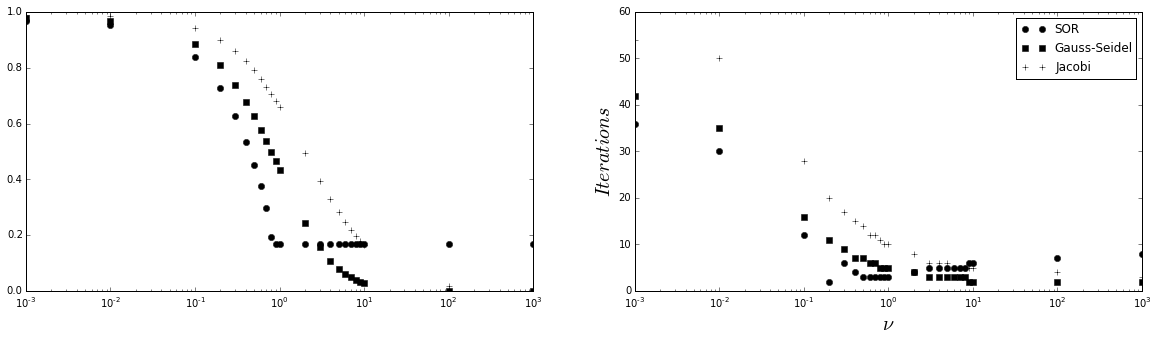

In [8]:
nu=[1.0e3,1.0e2,1.0e1,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0e0,.9,.8,.7,.6,.5,.4,.3,.2,1.0e-1,1.0e-2,1.0e-3]

#fig, axs = plt.subplots(1,2)
#,ax=axs[1]
plt.figure(figsize=(20,5))
plt.subplot(121)
for R in range(0,size(nu)): #Varies the value of nu
    [A,b]=dirichlet(n,nu[R],1,0,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]))
    
    [Q,Is,Ss]=space_iterate('sor',A,b,1)
    [Q,Ig,Sg]=space_iterate('gaussseidel',A,b,1)
    [Q,Ij,Sj]=space_iterate('jacobi',A,b,1)
    
    plt.semilogx(nu[R],Ss,'ok')
    plt.semilogx(nu[R],Sg,'sk')
    plt.semilogx(nu[R],Sj,'+k')
    
    
    if int == 1.0:
        plt.legend(['SOR','Gauss-Seidel','Jacobi'])
        #plt.title('Surface Velocity')
        plt.ylabel(r'$\rho$', fontsize=20)
        plt.xlabel(r'$\nu$', fontsize=20)
        
plt.subplot(122)
for R in range(0,size(nu)): #Varies the value of nu
    [A,b]=dirichlet(n,nu[R],1,0,matrix(arange(0,n+2)).T,matrix(arange(0,n+2)).T,K*ones([n+1,1]))
    
    [Q,Is,Ss]=space_iterate('sor',A,b,1)
    [Q,Ig,Sg]=space_iterate('gaussseidel',A,b,1)
    [Q,Ij,Sj]=space_iterate('jacobi',A,b,1)
    
    plt.semilogx(nu[R],Is,'ok')
    plt.semilogx(nu[R],Ig,'sk')
    plt.semilogx(nu[R],Ij,'+k')
    
    if R == 1.0:
        plt.legend(['SOR','Gauss-Seidel','Jacobi'])
        #plt.title('Surface Velocity')
        plt.ylabel(r'$Iterations$', fontsize=20)
        plt.xlabel(r'$\nu$', fontsize=20)


### Reviewing the effect of $\nu$

After plotting these values, it became apparent that further investigation of the SOR factor was needed. After testing the matrices with varying values for this factor, it appears that the factor can be chosen specifically for given conditions to maximize the code's efficiency. The downside of this is that the SOR method will become inaccurate if the SOR factor is *not* tailored to matrix $[A]$, i.e. adjusted relative to the magnitude of the terms $C_{k,k}$, as seen in the flat-lining of the SOR spectral radius for given values of $\nu$, or effectively values of $\frac{\nu}{C_{k,k}}$.

#### Questioning the effectiveness of the SOR code

As the SOR code appears to yield highly-consistent values for the number of iterations required, I am unsure as to whether the issue is with my SOR code, or if the issue is with the SOR procedure. I am not sure if there is a way to pre-calibrate the SOR factor to work with the given conditions, but I hope to look into this in the next week or so.

# 3. Convergence of the system on N

The system takes longer *time* to converge for matrices with larger N's, as the computations involve matrices of size N x N; however, it appears that the system requires the same number of iterations in spite of the spectral radius increasing (which should indicate that the procedure takes more iterations to reach the specified tolerance). This may be an artifact of my SOR code; further investigation is needed, which will take place this weekend and next week to iron out any bugs that I might be able to find in the SOR portion of my code. Fortunately, the Gauss-Seidel and Jacobi schemes appear to be working fine.

Iterations = 3; Spectral Radius = 0.17
Iterations = 5; Spectral Radius = 0.40916745174
Iterations = 10; Spectral Radius = 0.63966198241
Iterations = 3; Spectral Radius = 0.170000000003
Iterations = 5; Spectral Radius = 0.434571734619
Iterations = 10; Spectral Radius = 0.659220550817
Iterations = 3; Spectral Radius = 0.170000003055
Iterations = 5; Spectral Radius = 0.439895542501
Iterations = 10; Spectral Radius = 0.663246215595
Iterations = 3; Spectral Radius = 0.170005104274
Iterations = 5; Spectral Radius = 0.441840094173
Iterations = 10; Spectral Radius = 0.664710534122
Iterations = 3; Spectral Radius = 0.17582849741
Iterations = 5; Spectral Radius = 0.44276011326
Iterations = 10; Spectral Radius = 0.665402219158
Iterations = 3; Spectral Radius = 0.183489214452
Iterations = 5; Spectral Radius = 0.443266639025
Iterations = 10; Spectral Radius = 0.66578272659
Iterations = 3; Spectral Radius = 0.189147893655
Iterations = 5; Spectral Radius = 0.44357484935
Iterations = 10; Spectral Radi

/Users/bcorlett/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


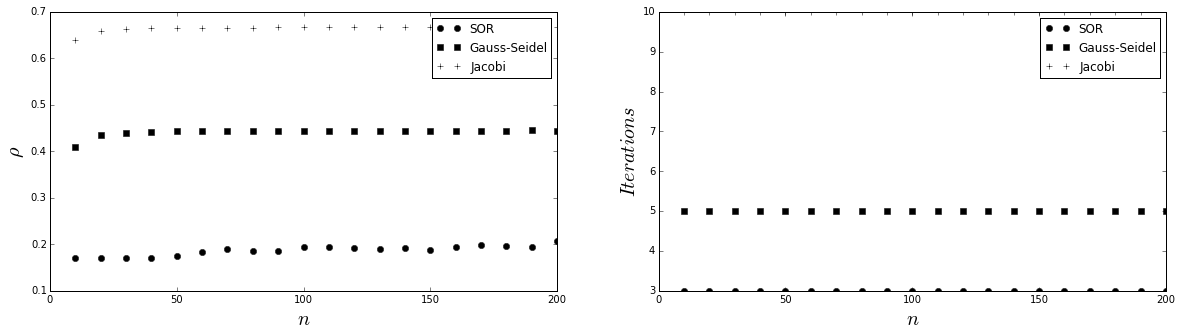

In [38]:
K=1.
v=1.
u0=0.
u1=1.

N=(arange(0,20)+1)*10

#fig, axs = plt.subplots(1,2)
#,ax=axs[1]
plt.figure(figsize=(20,5))
plt.subplot(121)

for R in range(0,size(N)): #Varies the value of n
    [A,b]=dirichlet(N[R],v,1,0,matrix(arange(0,N[R]+2)).T,matrix(arange(0,N[R]+2)).T,K*ones([N[R]+1,1]))
    
    [Q,Is,Ss]=space_iterate('sor',A,b,1)
    [Q,Ig,Sg]=space_iterate('gaussseidel',A,b,1)
    [Q,Ij,Sj]=space_iterate('jacobi',A,b,1)
    
    plt.plot(N[R],Ss,'ok')
    plt.plot(N[R],Sg,'sk')
    plt.plot(N[R],Sj,'+k')
    
    if R == 1.0:
        plt.legend(['SOR','Gauss-Seidel','Jacobi'])
        #plt.title('Surface Velocity')
        plt.ylabel(r'$\rho$', fontsize=20)
        plt.xlabel(r'$n$', fontsize=20)
        
plt.subplot(122)
for R in range(0,size(N)): #Varies the value of n
    [A,b]=dirichlet(N[R],v,1,0,matrix(arange(0,N[R]+2)).T,matrix(arange(0,N[R]+2)).T,K*ones([N[R]+1,1]))
    
    [Q,Is,Ss]=space_iterate('sor',A,b,1)
    [Q,Ig,Sg]=space_iterate('gaussseidel',A,b,1)
    [Q,Ij,Sj]=space_iterate('jacobi',A,b,1)
    
    plt.plot(N[R],Is,'ok')
    plt.plot(N[R],Ig,'sk')
    plt.plot(N[R],Ij,'+k')
    
    if R == 1.0:
        plt.legend(['SOR','Gauss-Seidel','Jacobi'])
        #plt.title('Surface Velocity')
        plt.ylabel(r'$Iterations$', fontsize=20)
        plt.xlabel(r'$n$', fontsize=20)

# 4. Estimate Iterations

The number of iterations required to reach a given error threshold ($\delta$) can be estimated by referring back to the base of our definition of the spectral radius ($\rho$). From $\rho = max(~|\lambda_{i}|~)$, where $\lambda_{i}$ are the eigenvalues of $\left[ B^{-1}C \right]$, from 
\begin{align}
    B x_{n+1} = b - C x_{n}
\end{align}
Taking $e_{n} = x_{n+1}-x_{n}$, we can simplify the above equation to 
\begin{align}
    e_{n} = \left[ B^{-1} C \right] e_{n-1}
\end{align}
Keeping in mind that $e_{n-1} = \left[ B^{-1} C \right] e_{n-2}$, we can further simplify to
\begin{align}
    e_{n} = \left[ B^{-1} C \right]^{n} e_{0}
\end{align}
where the final difference is a function of the initial difference times the basis of $\rho$ to some power. As we are requiring that $e_{n}$, or the difference between iterations, be smaller than some threshold ($\delta$), we can restate the problem as
\begin{align}
    e_{n} = \left[ B^{-1} C \right]^{n} e_{0} < \delta
\end{align}
where $n$ is the number of iterations required to reach our error threshold, and all values other than $n$ are matrices. Solving for $n$, we reach the following relation:
\begin{align}
    e_{0}^{-1} \delta > \left[ B^{-1}C \right]^{n} \\
    \frac{\log( e_{0}^{-1} \delta )}{\log( B^{-1}C )} < n \\
    \\
    \log( e_{0}^{-1} \delta ) - \log( B^{-1}C ) < n 
\end{align}

In effect, we can estimate the number of iterations required to reach the threshold by calculating the difference between our initial conditions and our first estimate ($e_{0}$), knowing $\delta$, and calculating $\left[ B^{-1}C \right]$ from our given system and boundary conditions. The number of iterations required to reach a given tolerance can be calculated, but depends on the specific conditions of the problem. In general, however, the smaller $\left[ B^{-1}C \right]$ becomes (and thus $\rho$), the faster the scheme will converge to the specified tolerance.

For a specified problem, the number of iterations required to reach a final result will also change depending on the method of iteration, as each method utilizes a different form of matrices $B$ and $C$, as shown previously.